# M5 - S3. Weekly Stationary

1. Load grid_df with imputed gaps and capped outliers
2. Switch to revnue target
3. Aggregate by week
4. Aggregate all levels (0-12)
5. Log scale -> minus Lag52 -> minus Lag4 (Bonus for BoxCox)
6. Perform stationarity test for all level timeseries

In [1]:
import warnings                                  # `do not disturbe` mode
warnings.filterwarnings('ignore')

import numpy as np                               # vectors and matrices
import pandas as pd                              # tables and data manipulations
import matplotlib.pyplot as plt                  # plots
import seaborn as sns                            # more plots

from dateutil.relativedelta import relativedelta # working with dates with style
from scipy.optimize import minimize              # for function minimization

#from scipy.stats import kurtosis
#from scipy.stats import skew
#from scipy import stats

import statsmodels.formula.api as smf            # statistics and econometrics
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
from scipy.sparse import csr_matrix

from sklearn.preprocessing import RobustScaler

from itertools import product                    # some useful functions
from tqdm import tqdm_notebook as tqdm
import gc

%matplotlib inline

In [2]:
# Memory reduction helper function:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns: #columns
        col_type = df[col].dtypes
        if col_type in numerics: #numerics
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

# Capped Outliers & Imputed Gaps:

1. Load the prepared grid_df from [M5 - Imputed Gaps & Capped Outliers](https://www.kaggle.com/sibmike/m5-imputed-gaps-capped-outlier)
2. Change "d" to "days_per_week" - number of days item has been sold per week

In [3]:
# Load grid with gaps and imputed sales:
cols = ['id', 'item_id', 'store_id', 'd', 'sales', 'level', 
        'wm_yr_wk_x', 'sell_price', 'month_start', 'clean_sales']

file_pass = '/kaggle/input/m5-s2-holidays/grid_s2.pkl'
grid_df = pd.read_pickle(file_pass)[cols]

In [4]:
# Switch true target to revenue:
grid_df.loc[:,'sales'] = grid_df.loc[:,'sales']*grid_df.loc[:,'sell_price']
grid_df.loc[:,'clean_sales'] = grid_df.loc[:,'clean_sales']*grid_df.loc[:,'sell_price']

In [5]:
# "d" - day number is meaningless for weekly aggregations.
# "days_per_week" - number of days item has been sold per week:
grid_df.rename(columns={"d": "days_per_week"}, inplace=True)
grid_df['days_per_week'] = 1
grid_df.loc[grid_df.sales.isna(),'days_per_week'] = 0
grid_df.loc[grid_df.clean_sales>0,'days_per_week'] = 0

In [6]:
grid_df.head()

,id,item_id,store_id,days_per_week,sales,level,wm_yr_wk_x,sell_price,month_start,clean_sales
0,HOBBIES_1_008_CA_1_validation,HOBBIES_1_008,CA_1,1,5.519531,11,11101,0.459961,False,NaN
1,HOBBIES_1_009_CA_1_validation,HOBBIES_1_009,CA_1,1,3.119141,11,11101,1.559570,False,NaN
2,HOBBIES_1_010_CA_1_validation,HOBBIES_1_010,CA_1,1,0.000000,11,11101,3.169922,False,NaN
3,HOBBIES_1_012_CA_1_validation,HOBBIES_1_012,CA_1,1,0.000000,11,11101,5.980469,False,NaN
4,HOBBIES_1_015_CA_1_validation,HOBBIES_1_015,CA_1,1,2.800781,11,11101,0.700195,False,NaN


# Week aggregations
1. Load roll_up dataframe and save its index.
2. Aggregate by week
3. Go from long to wide format with index by "item_id"
4. Allign "item_id" index with roll_up matrix index

In [7]:
# 1. Load roll_up dataframe
# Function to do quick rollups:
def rollup(v):
    '''
    v - np.array of size (30490 rows, n day columns)
    v_rolledup - array of size (n, 42840)
    '''
    return roll_mat_csr*v #(v.T*roll_mat_csr.T).T

# Load CSR matrix for quick Rollups:
## Define folder pass here:
file_pass = '/kaggle/input/fast-clear-wrmsse-18ms/'# '/kaggle/input/fast-wrmsse-and-sw-frame/'

## Load matrix and save rollup index:
roll_mat_df = reduce_mem_usage(pd.read_pickle(file_pass+'roll_mat_df.pkl'))
roll_index = roll_mat_df.index
roll_mat_csr = csr_matrix(roll_mat_df.values)
del roll_mat_df

Mem. usage decreased to 1247.46 Mb (0.0% reduction)


In [8]:
# Create week aggregations:
week_df = grid_df.groupby(['id','wm_yr_wk_x']).mean().fillna(0)
week_df.reset_index(inplace=True)

In [9]:
# Grid_df and Csr_matrix indices should be sorted in the same way:
sorted_idx = roll_index.to_frame().loc[11].id.index

# Prepare for Rollup by making every row an ID:
week_df = week_df.pivot(index='id', columns='wm_yr_wk_x').reindex(sorted_idx)

# Save columns for future use:
week_cols = week_df.columns

# Rollup: Level 0-10 Aggregations

In [10]:
# Rollup by multiplying by csr matrix:
roll_week_df = pd.DataFrame(rollup(week_df.values), index = roll_index, columns = week_cols)

# Return to long form:
roll_week_df = roll_week_df.T.unstack(level=1).T.reset_index()

# Reduce memory:
roll_week_df = reduce_mem_usage(roll_week_df)

del week_df, grid_df
gc.collect()

Mem. usage decreased to 306.66 Mb (57.8% reduction)


20

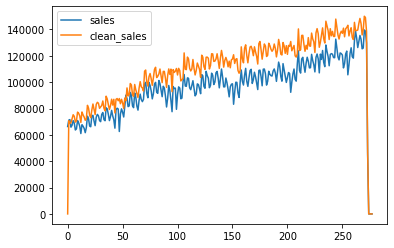

In [11]:
# Plot cleaned vs raw target aggragation:
roll_week_df[roll_week_df.id=='all'][['sales','clean_sales']].plot.line()

In [12]:
roll_week_df.head()

,level,id,wm_yr_wk_x,days_per_week,sales,sell_price,month_start,clean_sales
0,0,all,11101,10928.0,66317.539062,44506.511719,6248.0,0.000000
1,0,all,11102,11056.0,71162.093750,49834.378906,0.0,70713.242188
2,0,all,11103,4388.0,71572.398438,52459.703125,0.0,68641.101562
3,0,all,11104,5996.0,65826.851562,53765.566406,0.0,69211.125000
4,0,all,11105,5876.0,67309.804688,54776.667969,7448.0,72126.078125


In [13]:
# Dump to pickle:
roll_week_df = reduce_mem_usage(roll_week_df)
roll_week_df.to_pickle('grid_s3.pkl')

Mem. usage decreased to 306.66 Mb (0.0% reduction)


# Stationary Weekly Dataset
1. log
2. minus lag52
3. minus lag4

In [14]:
def substract_lag(col, lag):
    '''
    Substracts lag x from column.
    '''
    return (roll_week_df[col] - roll_week_df.groupby(['id'])[col].transform(lambda x: x.shift(lag))).astype(np.float32)

In [15]:
# Create stationary timeseries:
columns_to_modify = ['sales', 'clean_sales']
for col in columns_to_modify:
    roll_week_df.loc[:,f'{col}_log'] = np.log(roll_week_df.loc[:,col]+1)
    roll_week_df.loc[:,f'{col}_log_52'] = substract_lag(f'{col}_log', 52)
    roll_week_df.loc[:,f'{col}_log_52_4'] = substract_lag(f'{col}_log_52', 4)

# Plot & Test for Stationarity

In [16]:
def tsplot(y, lags=None, figsize=(12, 7), style='bmh'):
    """
        Plot time series, its ACF and PACF, calculate Dickey–Fuller test
        
        y - timeseries
        lags - how many lags to include in ACF, PACF calculation
    """
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        
        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()

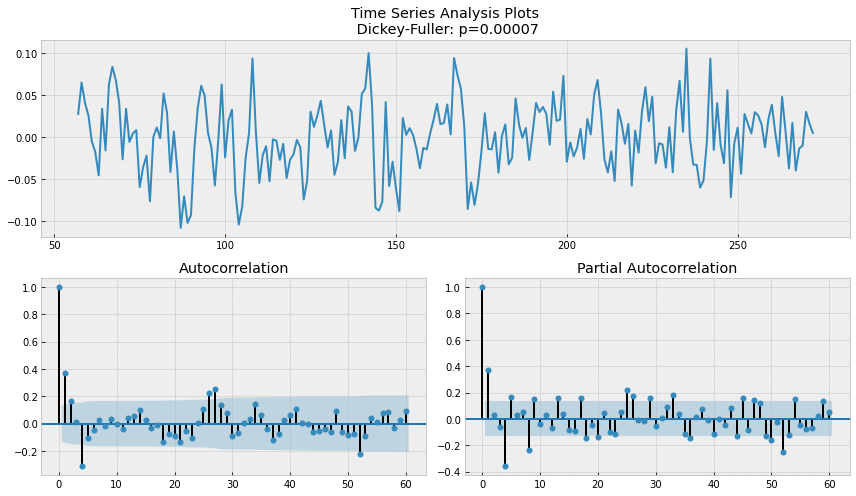

In [17]:
id_mask = roll_week_df.id=='all'
nan_mask = ~roll_week_df.sales_log_52_4.isna()
test_mask = roll_week_df.wm_yr_wk_x < (roll_week_df.wm_yr_wk_x.max() - 4)
lag_mask = roll_week_df.wm_yr_wk_x > (roll_week_df.wm_yr_wk_x.min() + 104)

ts = roll_week_df.loc[lag_mask&test_mask&id_mask&nan_mask,'sales_log_52_4']
tsplot(ts, lags=60)

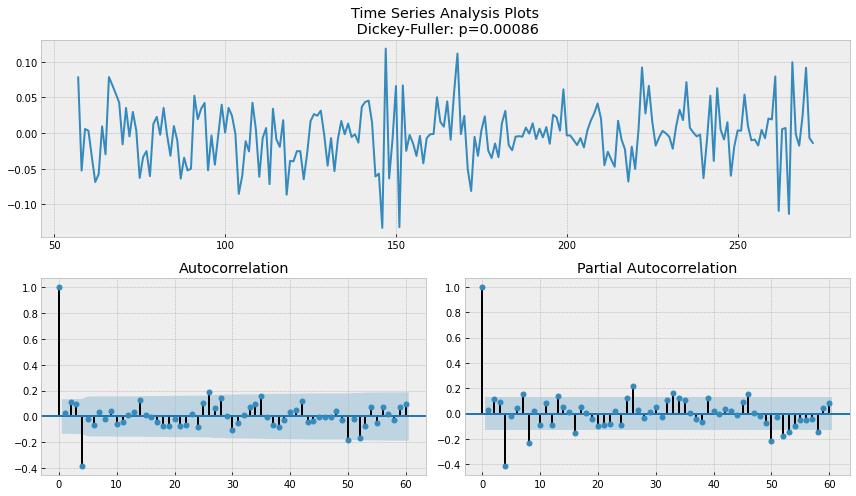

In [18]:
ts = roll_week_df.loc[lag_mask&test_mask&id_mask&nan_mask,'clean_sales_log_52_4']
tsplot(ts, lags=60)

In [19]:
# Dump to pickle:
roll_week_df = reduce_mem_usage(roll_week_df)
roll_week_df.to_pickle('grid_s3.pkl')

Mem. usage decreased to 442.95 Mb (23.5% reduction)


# Feature Engineering:

In [20]:
train_columns = ['level', 'id', 'wm_yr_wk_x', 'days_per_week', 
                 'sell_price', 'month_start', 'clean_sales_log_52_4']
train_df = roll_week_df[train_columns].copy()
del roll_week_df

In [21]:
train_df.rename(columns={"clean_sales_log_52_4": "target", 'wm_yr_wk_x':'wm_yr_wk'}, inplace=True)
train_df.loc[:,'target_zero'] = (train_df.target == 0).astype(np.float32)

## Lags
We have yearly seasonality (due to holidays, month ends, snaps etc) & 2 weeks cyclicity due to payroll.

* wlag_4 - same week last month
* wlag_6 - same bi-week last month
* wlag_8 - same week two month ago
* wlag_10 - same bi-week three month ago -> same as 1 week YoY
* wlag_52 - same week last year

In [22]:
def make_lag(TARGET, LAG_DAY):
    lag_df = train_df[['id','wm_yr_wk',TARGET]].copy()
    col_name = TARGET+'_lag_'+str(LAG_DAY)
    lag_df[col_name] = lag_df.groupby(['id'])[TARGET].transform(lambda x: x.shift(LAG_DAY)).astype(np.float32)
    return col_name, lag_df[[col_name]]

In [23]:
lags = [4,5,6,7,8,10,16,26,52]
lag_cols = ['target']

In [24]:
for TARGET in lag_cols:
    lag_df = train_df[['id','wm_yr_wk',TARGET]].copy()
    for LAG_DAY in tqdm(lags):
        col_name = TARGET+'_lag_'+str(LAG_DAY)
        train_df[col_name] = lag_df.groupby(['id'])[TARGET].transform(lambda x: x.shift(LAG_DAY)).astype(np.float32)
    del lag_df
    gc.collect()

In [25]:
gc.collect()

20

## Rollings averages

* Rolling avg w2_lag4 - 2 week average month ago
* Rolling avg w4_lag4 - 4 week average month ago -> will be used to build YoY
* Rolling avg, std, skew w12_lag4 - average for last 3 month -> will be used to build YoY
* Rolling avg, std, skew, trend? w24_lag4 - average for last 6 month -> will be used to build YoY
* Rolling avg, std, skew, trend? w52_lag4 - average for last year -> will be used to build YoY

In [26]:
def make_lag_roll(DF, TARGET, LAG_DAY, WINDOW, STATS):

    lag_df = train_df[['id','wm_yr_wk',TARGET]].copy()
    
    col_names = [TARGET + '_rolling_l'+str(LAG_DAY)+'_w'+str(WINDOW)+'_'+func for func in stats]
    lag_df[col_names] = lag_df.groupby(['id'])[TARGET].apply(lambda x: x.shift(LAG_DAY).rolling(WINDOW).agg(STATS).astype(np.float32))

    return col_names, lag_df[col_names]

In [27]:
lag_cols = ['target','days_per_week','target_zero']
wins = [12,26,52] 
stats = ['median', 'mean', 'std', 'min', 'max', 'skew']

In [28]:
LAG_DAY=4
for TARGET in lag_cols:
    lag_df = train_df[['id','wm_yr_wk',TARGET]].copy()
    for WINDOW in tqdm(wins):
        col_names = [TARGET + '_rolling_l'+str(LAG_DAY)+'_w'+str(WINDOW)+'_'+func for func in stats]
        train_df[col_names] = lag_df.groupby(['id'])[TARGET].apply(lambda x: x.shift(LAG_DAY).rolling(WINDOW).agg(stats).astype(np.float32))
    train_df = reduce_mem_usage(train_df)
    del lag_df
    gc.collect()


Mem. usage decreased to 874.55 Mb (42.1% reduction)



Mem. usage decreased to 1283.43 Mb (24.2% reduction)



Mem. usage decreased to 1692.31 Mb (19.5% reduction)


In [29]:
gc.collect()

20

In [30]:
train_df.to_pickle('train_s3.pkl')

# Mean, std encoding